In [1]:
import pandas as pd
import numpy as np
import seaborn as sns  
import matplotlib.pyplot as plt
from datetime import date
from dateutil.relativedelta import relativedelta
%matplotlib inline 

# IMPORTANT:
# Redownload the files from slack and Outlook 

##### DATA (the anonymised dataframe) 

In [2]:
#import main dataframe
data = pd.read_csv('locations.csv', low_memory=False)

In [3]:
#rename City column and drop empty columns
data.rename( columns={'Unnamed: 5':'City'}, inplace=True )
data = data.drop(data.columns[data.columns.str.contains('unnamed',case = False)],axis = 1)

In [4]:
#drop VisitorID and ContentInfo
data = data.drop(columns=['VisitorID', 'ContentInfo'])

In [5]:
#just getting rid of the space after the name
data = data.replace('STH Ayshire St Leonards ', 'STH Ayshire St Leonards')

In [6]:
#drop nan in Building
data = data.dropna(subset=['Building'])

In [7]:
#change time to datetime
data['Time'] = pd.to_datetime(data['Time'], format = "%d/%m/%Y %H:%M", utc=False)
data.head()

,Time,ExternalID,Role,Building,City,LinkTitle,LinkType
0,2018-10-29 10:55:00,5325.0,User,Broom Ground,Stirling,Sam Smith,Internet
1,2018-10-29 10:50:00,5325.0,User,Broom Ground,Stirling,Elton John,Internet
2,2018-10-29 10:49:00,5325.0,User,Broom Ground,Stirling,My Music,Category
3,2018-10-29 10:49:00,5325.0,User,Broom Ground,Stirling,Entertainment,Category
4,2018-10-29 10:48:00,NaN,User,Belses Gardens - Care Home,Glasgow,BBC Formula 1,Internet


In [8]:
#change ExternalIDs to integers
data.ExternalID = data.ExternalID.fillna(0).astype(int)

In [9]:
#drop rows that are identical
data = data.drop_duplicates(keep='first')

In [10]:
#new dataframe with no null ExternalID vaues
data = data[data.ExternalID != 0]

##### USERS (the user dataframe) 

In [11]:
#import users dataframe
users = pd.read_csv('PrimaryConditions age sex by customer reference.csv', low_memory=False)

In [12]:
#drop empty column and CleverCogsUserId
users = users.drop(users.columns[users.columns.str.contains('unnamed',case = False)],axis = 1)
users = users.drop(columns=['CleverCogsUserId'])

In [13]:
#delete empty row
users = users.dropna(axis=0, how='all', inplace=False)

In [14]:
#change ExternalID into integers
users['ExternalID'] = users['ExternalID'].apply(np.int64)
users.shape
users.head()

,ExternalID,BirthDate,Gender,Condition
0,4703,04/07/1965,F,Spina Bifida
1,4704,21/06/1940,F,COPD
2,4706,25/02/1931,F,Dementia
3,4707,18/09/1982,F,Brain Injury
4,4708,20/12/1931,F,NaN


In [15]:
#drop duplicates
users = users.drop_duplicates(subset = ['ExternalID'], keep='last')
users.shape

(680, 4)

In [16]:
#change BirthDate to date time
#users['BirthDate'] = pd.to_datetime(users['BirthDate'], format = "%m/%d/%y", dayfirst=False, utc=True)

users['BirthDate'] = pd.to_datetime(users['BirthDate'], errors='coerce', dayfirst=False, yearfirst=False, 
                   format="%d/%m/%Y", utc=False, infer_datetime_format=False, origin='unix')
users = users.set_index(pd.DatetimeIndex(users['BirthDate']))

#Remove erroneous entries
threshold = pd.to_datetime("2010-01-01", format="%Y-%m-%d", utc=False, origin='unix')
users = users[users['BirthDate'] < threshold]

users.head()

,ExternalID,BirthDate,Gender,Condition
BirthDate,,,,
1965-07-04,4703,1965-07-04,F,Spina Bifida
1940-06-21,4704,1940-06-21,F,COPD
1931-02-25,4706,1931-02-25,F,Dementia
1982-09-18,4707,1982-09-18,F,Brain Injury
1931-12-20,4708,1931-12-20,F,NaN


In [17]:
now = pd.to_datetime(date.today())

def getYears(start):
    diff = relativedelta(now, start)
    return diff.years

# Add a new column that contains the age of the user
users["Age"] = users['BirthDate'].map(getYears)

In [18]:
users.head()

,ExternalID,BirthDate,Gender,Condition,Age
BirthDate,,,,,
1965-07-04,4703,1965-07-04,F,Spina Bifida,53
1940-06-21,4704,1940-06-21,F,COPD,78
1931-02-25,4706,1931-02-25,F,Dementia,87
1982-09-18,4707,1982-09-18,F,Brain Injury,36
1931-12-20,4708,1931-12-20,F,NaN,86


In [19]:
#print all Cities, drop or group unneccessary
city = data.City.unique()
index = 1
for item in city:
    print(index, ': ', item)
    index += 1

1 :  Stirling
2 :  Ayr
3 :  Edinburgh
4 :  Dundee
5 :  Aberdeen
6 :  Dundee (Tayside)
7 :  test user
8 :  Glasgow
9 :  Arbroath (Tayside)


In [20]:
data = data.replace('Dundee (Tayside)', 'Dundee')
#replace Arbroath with Dundee, since they are very close and there is only 1 user in Arbroath-->generalise location
data = data.replace('Arbroath (Tayside)', 'Dundee')

In [21]:
#drop rows when assumed data is not from actual user
data = data[(data.City != 'Test user ignore') & (data.City != 'test user')]

In [22]:
city = data.City.unique()
index = 1
for item in city:
    print(index, ': ', item)
    index += 1

1 :  Stirling
2 :  Ayr
3 :  Edinburgh
4 :  Dundee
5 :  Aberdeen
6 :  Glasgow


In [23]:
#Count the number of the users in each City
print ('Number of users in total : ', data.ExternalID.nunique())

numberOfUsers = data.groupby('City')['ExternalID'].nunique().reset_index(name='NumberOfUsers')

#add column NumberOfUsers on the dataframe
data = pd.merge(data, numberOfUsers, on = 'City', how='left')

print (numberOfUsers)
np.sum(numberOfUsers)

Number of users in total :  93
        City  NumberOfUsers
0   Aberdeen              9
1        Ayr             11
2     Dundee             22
3  Edinburgh             27
4    Glasgow              6
5   Stirling             18


City             AberdeenAyrDundeeEdinburghGlasgowStirling
NumberOfUsers                                           93
dtype: object

In [24]:
#Calculate number of clicks per each location over period of 10 months
logs = data['City'].value_counts().reset_index(name='NumberOfClicks')
logs.columns = logs.columns.str.replace('index','City')

##add column NumberOfClicks on the dataframe
data = pd.merge(data, logs, on = 'City', how='left')

print(logs)

        City  NumberOfClicks
0  Edinburgh           24442
1   Stirling           21632
2        Ayr           18599
3     Dundee           16826
4   Aberdeen            4015
5    Glasgow            2099


In [25]:
#calculate average of cliks per person
data['AverageUsage'] = data.NumberOfClicks / data.NumberOfUsers

In [26]:
#define months and assign index
january = pd.to_datetime("2018-01-31", format="%Y-%m-%d", utc=False, origin='unix')
february = pd.to_datetime("2018-02-28", format="%Y-%m-%d", utc=False, origin='unix')
march = pd.to_datetime("2018-03-31", format="%Y-%m-%d", utc=False, origin='unix')
april = pd.to_datetime("2018-04-30", format="%Y-%m-%d", utc=False, origin='unix')
may = pd.to_datetime("2018-05-31", format="%Y-%m-%d", utc=False, origin='unix')
june = pd.to_datetime("2018-06-30", format="%Y-%m-%d", utc=False, origin='unix')
july = pd.to_datetime("2018-07-31", format="%Y-%m-%d", utc=False, origin='unix')
august = pd.to_datetime("2018-08-31", format="%Y-%m-%d", utc=False, origin='unix')
september = pd.to_datetime("2018-09-30", format="%Y-%m-%d", utc=False, origin='unix')
october = pd.to_datetime("2018-10-31", format="%Y-%m-%d", utc=False, origin='unix')

def months(date):
    if date <= january:
        return 'January'
    elif january < date <= february:
        return 'February'
    elif february < date <= march:
        return 'March'
    elif march < date <= april:
        return 'April'
    elif april < date <= may:
        return 'May'
    elif may < date <= june:
        return 'June'
    elif june < date <= july:
        return 'July'
    elif july < date <= august:
        return 'August'
    elif august < date <= september:
        return 'September'
    elif september < date <= october:
        return 'October'
    
def monthindex(month):
    if month == 'January':
        return 1
    elif month == 'February':
        return 2
    elif month == 'March':
        return 3
    elif month == 'April':
        return 4
    elif month == 'May':
        return 5
    elif month == 'June':
        return 6
    if month == 'July':
        return 7
    elif month == 'August':
        return 8
    elif month == 'September':
        return 9
    else:
        return 10

data['Month'] = data['Time'].map(months)
data['MonthIndex'] = data['Month'].map(monthindex)

In [27]:
ClicksPerMonth = data.groupby(['Month', 'City','MonthIndex', 'NumberOfUsers'])['ExternalID'].count().reset_index(name='ClicksPerMonth').sort_values(by=['MonthIndex'])
ClicksPerMonth['AverageUsageMonth'] = ClicksPerMonth['ClicksPerMonth'] / ClicksPerMonth['NumberOfUsers']

In [28]:
data.head()

,Time,ExternalID,Role,Building,City,LinkTitle,LinkType,NumberOfUsers,NumberOfClicks,AverageUsage,Month,MonthIndex
0,2018-10-29 10:55:00,5325,User,Broom Ground,Stirling,Sam Smith,Internet,18,21632,1201.777778,October,10
1,2018-10-29 10:50:00,5325,User,Broom Ground,Stirling,Elton John,Internet,18,21632,1201.777778,October,10
2,2018-10-29 10:49:00,5325,User,Broom Ground,Stirling,My Music,Category,18,21632,1201.777778,October,10
3,2018-10-29 10:49:00,5325,User,Broom Ground,Stirling,Entertainment,Category,18,21632,1201.777778,October,10
4,2018-10-29 10:41:00,5541,User,STH Ayshire St Leonards,Ayr,YouTube,Internet,11,18599,1690.818182,October,10


/Users/Mojca/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/Mojca/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/Mojca/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/Mojca/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnin

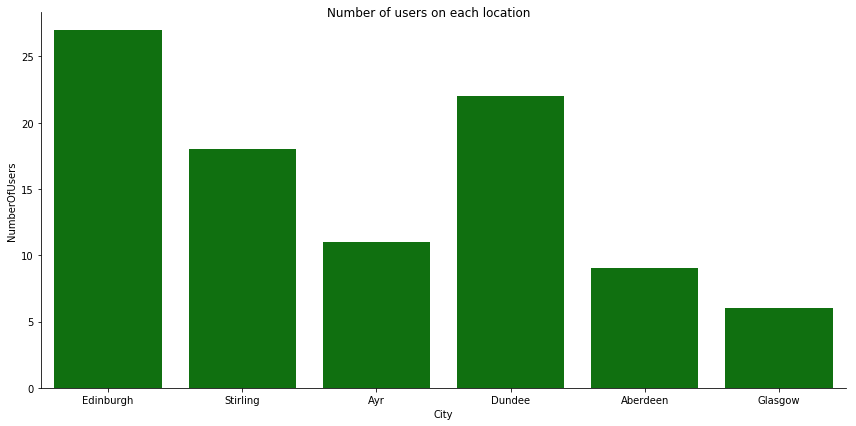

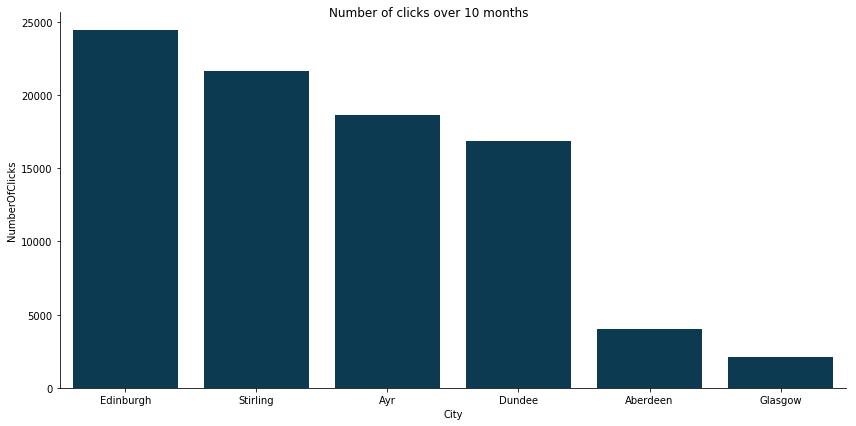

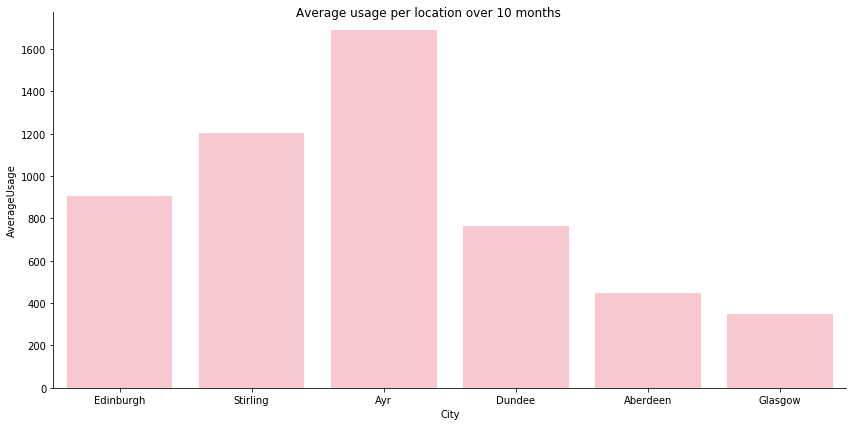

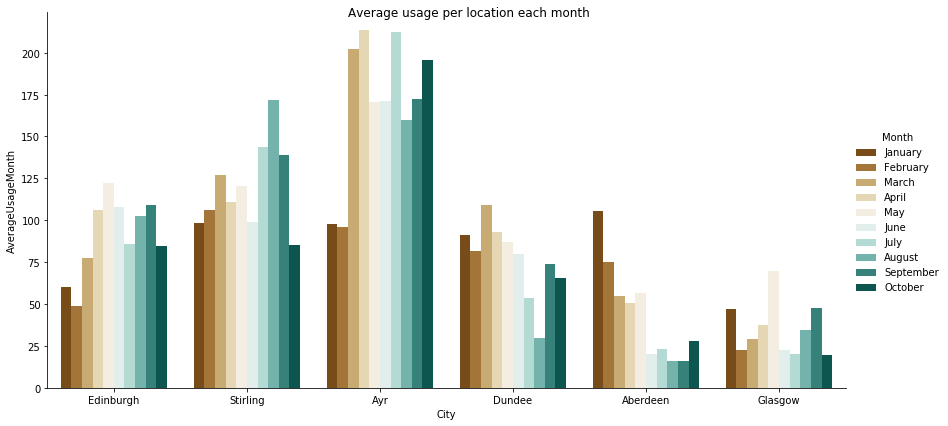

In [29]:
UsersInCity = sns.catplot(x='City', y='NumberOfUsers', kind='bar', color="green", data=data, size=6, aspect=2, order=data['City'].value_counts().index)
UsersInCity.fig.suptitle('Number of users on each location')
plt.savefig("UsersInCity.svg")

FrequencyUsersCity = sns.catplot(x='City', y='NumberOfClicks', kind='bar', color="#003f5c", data=data, size=6, aspect=2, order=data['City'].value_counts().index)
FrequencyUsersCity.fig.suptitle('Number of clicks over 10 months')
plt.savefig("FrequencyUsersCity.svg")

AverageUsageCity = sns.catplot(x='City', y='AverageUsage', kind='bar', color="pink", data=data, size=6, aspect=2, order=data['City'].value_counts().index)
AverageUsageCity.fig.suptitle('Average usage per location over 10 months')
plt.savefig("AverageUsageCity.svg")

MonthActivity = sns.catplot(x='City', y='AverageUsageMonth', hue='Month', kind='bar', palette=sns.color_palette("BrBG", 10), data=ClicksPerMonth, size=6, aspect=2, order=data['City'].value_counts().index)
MonthActivity.fig.suptitle('Average usage per location each month')
plt.savefig("MonthActivity.svg")


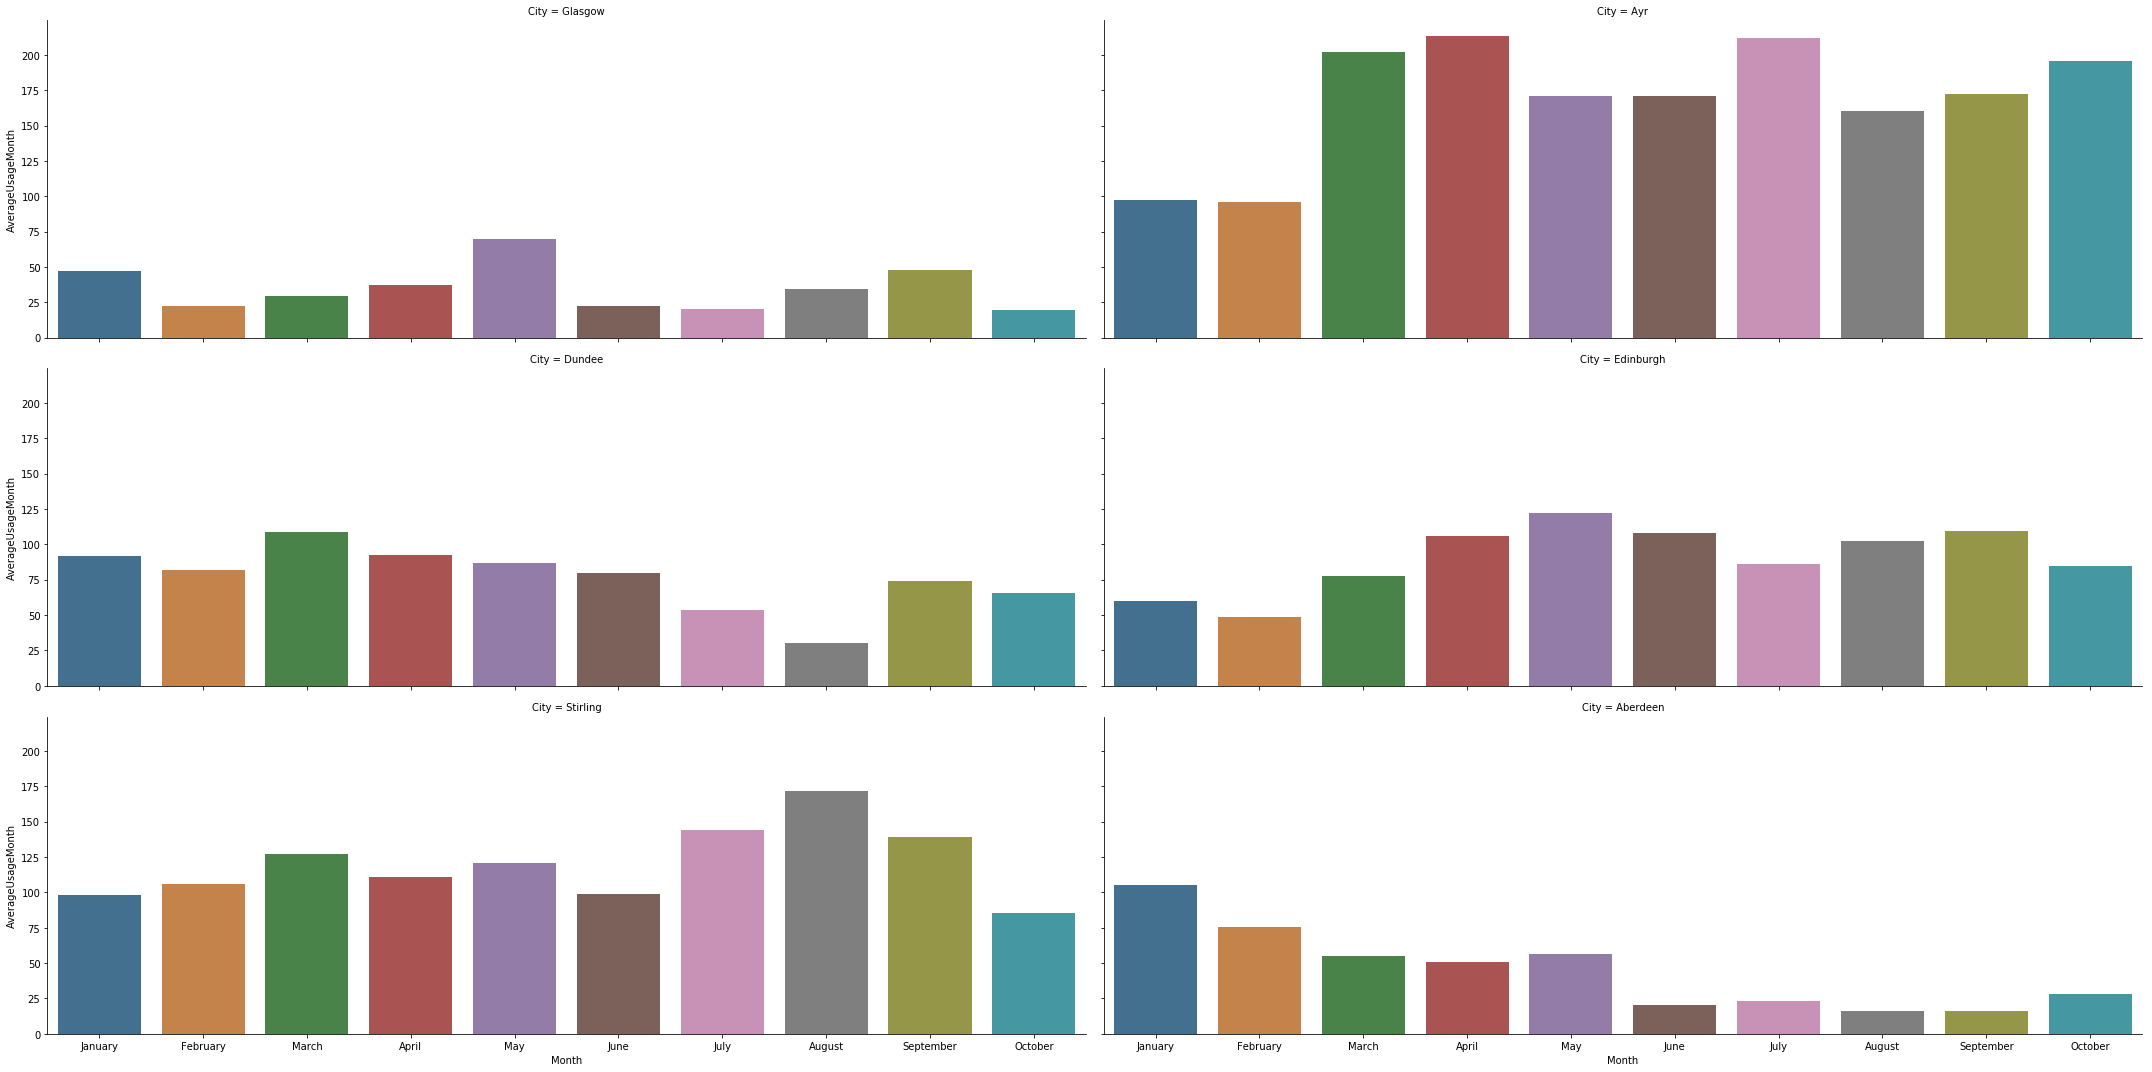

In [30]:
sns.catplot(x="Month", y="AverageUsageMonth", col="City", col_wrap=2,
            data=ClicksPerMonth, saturation=.5,
            kind="bar", ci=None, aspect=3,)
plt.savefig("MonthActivityByMonths.svg")